# XGBoost Model with Transformer Embeddings and PCA

This notebook outlines the process for building and ealuating an XGBoost model with principal component analysis using two columns from the "merged.csv" dataset consisting of `chiefcomplaint` and `disposition`. The process includes:

- Create embeddings for `chiefcomplaint` using the transformer model `BAAI/bge-large-en`
- Saving the embeddings to disk
- Reducing dimensions with PCA and visualizing explained variance (see pca.ipynb)
- Preprocessing target labels and normalizing features
- Splitting data into training and test sets, saving test sets
- Hyperparameter tuning using kfold validation and grid search
- Training a final XGBoost model and evaluating performance
- Saving the final model and associated preprocessing objects

In [10]:
import sys
sys.path.append('..')

import os
import warnings
import joblib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from joblib import Parallel, delayed, parallel_backend
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.utils import shuffle
from xgboost import XGBClassifier

from transformers import AutoTokenizer, AutoModel

from utils.data_utils import load_data, process_data_for_xgboost
from utils.embeddings import EmbeddingExtractor
from utils.evaluation import evaluate_model

from IPython.display import display, Markdown

# Set random seed
RANDOM_STATE = 42
SAMPLE_SIZE = 1000
DEFAULT_PCA_COMPONENTS = 80
EMBEDDING_MODEL_NAME = "BAAI/bge-m3"

# disable "This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable."
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

### Load Data

We load the pre-cleaned data, and extract text embeddings from the `chiefcomplaint` field using the transformer model.

In [11]:
df_10k = load_data('../data/train.csv', SAMPLE_SIZE)
df_10k.shape

(1000, 37)

### Load Embeddings

In [12]:
embedder = EmbeddingExtractor()
embeddings = embedder.get_or_create_embeddings(df_10k)
print(f"Final embeddings shape: {embeddings.shape}")

Loading cached embeddings from embeddings\embeddings_c02b40ebda187d7d215640e3e1a26cac.joblib...
Loaded existing embeddings, shape: (1000, 1024)
Final embeddings shape: (1000, 1024)


## Data Preprocessing

### PCA for Dimensionality Reduction

We apply PCA to the embeddings and plot the cumulative explained variance to show how many components are needed.

#### PCA Evaluation and Decision

After evaluating multiple metrics—including the cumulative explained variance, scree plot, eigenvalue analysis, and parallel analysis—the following insights were obtained:

- **95% Variance Threshold:** The analysis on full-dimensional PCA indicated that a larger number of components are needed to capture 95% of the variance.
- **Scree Plot & Eigenvalue Analysis:** These methods revealed a significant drop in variance explained after the initial components, with many later components having eigenvalues less than 1.
- **Parallel Analysis:** Comparing the eigenvalues from the real data against those from random data confirmed that many components in the full dataset contribute minimal unique information.
- **Comparison for Specific Component Counts:** When evaluating selected component counts (53, 80, 89, 96), the 80-component solution achieved a substantial retention of variance while avoiding unnecessary complexity.

**Final Components:** We have chosen **80 components** as the optimal balance between dimensionality reduction and preserving the integrity of the data. This choice improves model efficiency and reduces noise without sacrificing key information.


In [13]:
# Scale data, get scaler and label_encoder
xgb_obj = process_data_for_xgboost(embeddings, df_10k['disposition'], training=True)
X = xgb_obj['X']
y = xgb_obj['y']
scaler = xgb_obj['scaler']
pca = xgb_obj['pca']


# Then split the PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [14]:
def plot_pca_variance(ax, pca, title='PCA Explained Variance vs. Number of Components', threshold=0.90):
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(range(1, len(cum_var)+1), cum_var, marker='o')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance')
    ax.set_title(title)
    ax.axhline(y=threshold, color='r', linestyle='--', label=f'{int(threshold*100)}% Variance')
    ax.legend()
    ax.grid(True)


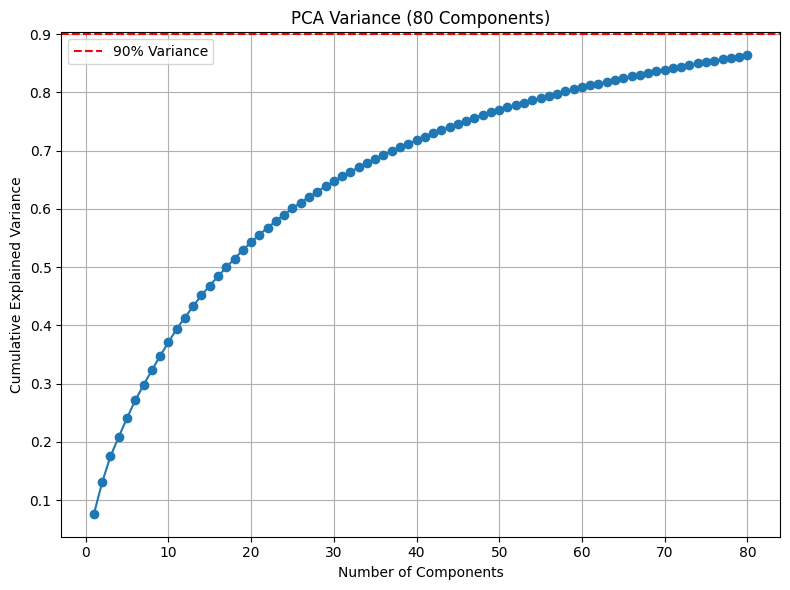

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
plot_pca_variance(ax, pca, title='PCA Variance (80 Components)', threshold=0.90)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning with XGBoost

We use GridSearchCV with cross-validation on the subset to tune XGBoost hyperparameters.

In [16]:
def tune_xgboost(X, y):
    print(f"Performing hyperparameter tuning using {X.shape[0]} rows")
    
    # Check CUDA availability
    import torch
    cuda_available = torch.cuda.is_available()
    device = 'cuda' if cuda_available else 'cpu'
    
    param_grid = {
        "n_estimators": [50, 100],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.7, 1.0],
        "tree_method": ["hist"],
        "device": [device]  # Use the detected device
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    param_list = list(ParameterGrid(param_grid))

    def evaluate_params(params):
        scores = []
        last_model = None
        for train_idx, val_idx in cv.split(X, y):
            # Split the data (which is already PCA transformed)
            if isinstance(X, pd.DataFrame):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            else:
                X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Create model with the detected device
            model = XGBClassifier(
                **params,
                eval_metric="logloss",
                random_state=RANDOM_STATE,
                n_jobs=1
            )
            
            # If using GPU, ensure data is on GPU
            if params['device'] == 'cuda':
                try:
                    # Convert to torch tensor and back to ensure GPU compatibility
                    X_train_device = torch.tensor(X_train).cuda().cpu().numpy()
                    X_val_device = torch.tensor(X_val).cuda().cpu().numpy()
                    
                    model.fit(
                        X_train_device, y_train,
                        eval_set=[(X_val_device, y_val)],
                        verbose=False
                    )
                    preds = model.predict(X_val_device)
                except Exception as e:
                    print(f"GPU error: {e}, falling back to CPU")
                    # Fall back to CPU if GPU fails
                    params['device'] = 'cpu'
                    model.set_param({'device': 'cpu'})
                    model.fit(
                        X_train, y_train,
                        eval_set=[(X_val, y_val)],
                        verbose=False
                    )
                    preds = model.predict(X_val)
            else:
                # CPU training
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
                preds = model.predict(X_val)
                
            scores.append(accuracy_score(y_val, preds))
            last_model = model
        return np.mean(scores), params, last_model

    results = Parallel(n_jobs=2)(
        delayed(evaluate_params)(params) for params in tqdm(param_list, desc="Tuning XGBoost")
    )
    best_score, best_params, best_model = max(results, key=lambda x: x[0])
    return best_model, best_params

In [17]:
# Run on sample dataset
best_model, best_params = tune_xgboost(X_train, y_train)


Performing hyperparameter tuning using 900 rows


Tuning XGBoost: 100%|██████████| 36/36 [00:56<00:00,  1.56s/it]


In [18]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')
print("Best Parameters:", best_params)
print("Subset Validation Accuracy:", accuracy_score(y_test, best_model.predict(X_test)))

Best Parameters: {'device': 'cuda', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0, 'tree_method': 'hist'}
Subset Validation Accuracy: 0.62


## Final Training and Evaluation

Using the tuned parameters, we train the final XGBoost model on the full dataset split and evaluate its performance.

In [19]:
# Save the final model and preprocessors
# os.makedirs("models", exist_ok=True)
# joblib.dump(best_model, "models/xgboost_model.pkl")
# joblib.dump(scaler, "models/xgb_scaler.pkl")
# joblib.dump(pca, "models/xgb_pca.pkl")
# joblib.dump(encoder, "models/xgb_encoder.pkl")
# print("Model and preprocessors saved.")

y_pred = best_model.predict(X_test)
print("Best Model Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Model Test Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.48      0.32      0.39        37
           1       0.67      0.79      0.72        63

    accuracy                           0.62       100
   macro avg       0.57      0.56      0.56       100
weighted avg       0.60      0.62      0.60       100



### Train the best model on the full data set now

In [21]:
# Load all data
df_full = load_data('../data/train.csv')
print("Dataframe shape:", df_full.shape)

# Create embeddings, comment out if already done
embedder = EmbeddingExtractor()
embeddings = embedder.get_or_create_embeddings(df_full)
print(f"Final embeddings shape: {embeddings.shape}")

# Process data, scale, encode, apply pca
xgb_obj = process_data_for_xgboost(embeddings, df_full['disposition'], training=True)
X = xgb_obj['X']
y = xgb_obj['y']
scaler = xgb_obj['scaler']
encoder= xgb_obj['encoder']
pca = xgb_obj['pca']

# Then split the PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Find the best parameters:
best_model, best_params = tune_xgboost(X_train, y_train)

# Train a final model
xgb_model = XGBClassifier(**best_params, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

# Test final model
y_predictions = xgb_model.predict(X_test)
y_probabilities = xgb_model.predict_proba(X_test)[:,1]

xgb_metrics, xgb_markdown = evaluate_model(
    y_test, 
    y_predictions,
    y_probabilities,
    model_name="XGBoost",
    label_encoder=encoder
)

display(Markdown(xgb_markdown))

# Save the final model and preprocessors
os.makedirs("models", exist_ok=True)
joblib.dump(xgb_model, "models/xgboost_model.pkl")
joblib.dump(X_test, "models/xgb_X_test.pkl")
joblib.dump(y_test, "models/xgb_y_test.pkl")
joblib.dump(scaler, "models/xgb_scaler.pkl")
joblib.dump(encoder, "models/xgb_encoder.pkl")
joblib.dump(pca, "models/xgb_pca.pkl")
print("Model and preprocessors saved.")

Dataframe shape: (410326, 37)
Creating new embeddings... Reason: Cache file not found


Extracting embeddings: 100%|██████████| 410326/410326 [1:30:10<00:00, 75.84it/s]  


Created embeddings, shape: (410326, 1024)
Cached embeddings saved to embeddings\embeddings_a5cc2cfb75154104141f360e5b20d650.joblib
Final embeddings shape: (410326, 1024)
Performing hyperparameter tuning using 369293 rows


Tuning XGBoost: 100%|██████████| 36/36 [07:15<00:00, 12.10s/it]


# XGBoost Evaluation Results

## Metrics

| Metric                    | Score    |
|---------------------------|----------|
| Validation Accuracy       | 0.7371 |
| Validation F1 Score (weighted) | 0.7288 |
| Validation Precision (weighted) | 0.7343 |
| Validation Recall (class 1) | 0.8602 |
| Binary Precision (class 1) | 0.7460 |
| Binary F1 Score (class 1) | 0.7991 |
| ROC-AUC Score             | 0.7952 |

## Detailed Classification Report

```
              precision    recall  f1-score   support

           0       0.72      0.55      0.62     16100
           1       0.75      0.86      0.80     24933

    accuracy                           0.74     41033
   macro avg       0.73      0.70      0.71     41033
weighted avg       0.73      0.74      0.73     41033

```

## Sample of Predictions in Original Labels

`['HOME' 'HOME' 'HOME' 'ADMITTED' 'ADMITTED'] ...`


Model and preprocessors saved.


In [22]:

# Load the saved model and make predictions
xgb_model = joblib.load("models/xgboost_model.pkl")

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

xgb_metrics, xgb_markdown = evaluate_model(
    y_test, 
    y_pred,
    y_prob,
    model_name="XGBoost",
    label_encoder=encoder
)

display(Markdown(xgb_markdown))


# XGBoost Evaluation Results

## Metrics

| Metric                    | Score    |
|---------------------------|----------|
| Validation Accuracy       | 0.7371 |
| Validation F1 Score (weighted) | 0.7288 |
| Validation Precision (weighted) | 0.7343 |
| Validation Recall (class 1) | 0.8602 |
| Binary Precision (class 1) | 0.7460 |
| Binary F1 Score (class 1) | 0.7991 |
| ROC-AUC Score             | 0.7952 |

## Detailed Classification Report

```
              precision    recall  f1-score   support

           0       0.72      0.55      0.62     16100
           1       0.75      0.86      0.80     24933

    accuracy                           0.74     41033
   macro avg       0.73      0.70      0.71     41033
weighted avg       0.73      0.74      0.73     41033

```

## Sample of Predictions in Original Labels

`['HOME' 'HOME' 'HOME' 'ADMITTED' 'ADMITTED'] ...`


## Conclusion

The model shows moderate performance overall. Its AUC-ROC of 0.79 indicates decent discrimination between the admit and home classes, and an accuracy of 0.73 supports this. Notably, the model performs particularly well for predicting admissions (class 1), achieving a high recall of 0.86 and an F1 score of 0.80, which suggests it is effective at identifying patients who will be admitted. However, the lower recall (0.54) for predicting home discharges (class 0) indicates it misses a significant portion of those cases. Overall, while the weighted F1 score of 0.73 is reasonable, there’s room for improvement, especially in accurately identifying patients who will be discharged home.

The final model and all preprocessing objects have been saved for future inference. Please refer to the last cell for details. 

In [30]:
# Save the final model and preprocessors
os.makedirs("models", exist_ok=True)
joblib.dump(xgb_model, "models/xgboost_model.pkl")
joblib.dump(X_test, "models/xgb_X_test.pkl")
joblib.dump(y_test, "models/xgb_y_test.pkl")
joblib.dump(scaler, "models/xgb_scaler.pkl")
joblib.dump(encoder, "models/xgb_encoder.pkl")
joblib.dump(pca, "models/xgb_pca.pkl")
print("Model and preprocessors saved.")

Model and preprocessors saved.


In [31]:
# Load saved preprocessing objects and model
scaler = joblib.load('models/xgb_scaler.pkl')
encoder = joblib.load('models/xgb_encoder.pkl')
xgb_model = joblib.load('models/xgboost_model.pkl')
pca_obj = joblib.load('models/xgb_pca.pkl')

In [33]:
val_df = pd.read_csv('../data/validation.csv')

# Process data for XGBoost
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    embedder = EmbeddingExtractor()
    embeddings = embedder.get_or_create_embeddings(val_df)
    xgb_obj = process_data_for_xgboost(embeddings, 
                                       val_df['disposition'],
                                       pca_obj=pca_obj,
                                       training=False,)
    xgb_X = xgb_obj['X']
    xgb_y = xgb_obj['y']
    
xgb_y_predictions = xgb_model.predict(xgb_X)
xgb_y_probabilities = xgb_model.predict_proba(xgb_X)[:,1]

# For XGBoost
xgb_metrics, xgb_markdown = evaluate_model(
    xgb_y, 
    xgb_y_predictions,
    xgb_y_probabilities,
    model_name="XGBoost",
    label_encoder=encoder
)

display(Markdown(xgb_markdown))

Creating new embeddings... Reason: Cache file not found


Extracting embeddings: 100%|██████████| 10000/10000 [01:54<00:00, 87.49it/s]


Created embeddings, shape: (10000, 1024)
Cached embeddings saved to embeddings\embeddings_72b6a1c2c4649a83369e1c627e8fc462.joblib


# XGBoost Evaluation Results

## Metrics

| Metric                    | Score    |
|---------------------------|----------|
| Validation Accuracy       | 0.7252 |
| Validation F1 Score (weighted) | 0.7160 |
| Validation Precision (weighted) | 0.7226 |
| Validation Recall (class 1) | 0.8547 |
| Binary Precision (class 1) | 0.7329 |
| Binary F1 Score (class 1) | 0.7891 |
| ROC-AUC Score             | 0.7848 |

## Detailed Classification Report

```
              precision    recall  f1-score   support

           0       0.71      0.53      0.61      3984
           1       0.73      0.85      0.79      6016

    accuracy                           0.73     10000
   macro avg       0.72      0.69      0.70     10000
weighted avg       0.72      0.73      0.72     10000

```

## Sample of Predictions in Original Labels

`['HOME' 'ADMITTED' 'HOME' 'ADMITTED' 'HOME'] ...`
